In [1]:
import numpy as np
import scipy.sparse as sp
from sklearn.preprocessing
import normalize
import util
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import NMF

There are two most popular methods to build a recommender system : **Collaborative Filtering (CF)** and **Content-Based**. Furthermore, Collaborative Filtering can be divided into **Memory-Based** and **Model-Based**. We will try both methods in the following sections.

In [2]:
# load the rating matrix
M = util.load_sparse_csr("imdb_data/rating.npz").toarray()
movie_names = np.load("imdb_data/movies.npy")
user_names = np.load("imdb_data/users.npy")

In order to evaluate our recommender systems, we need to firstly split the whole dataset to train dataset and test dataset. Before doing that, we apply a filter to remove users who have rated less than 5 movies and movies which do not have more than 5 reviews. In this way we reduce the sparsity of the rating matrix from *0.09%* to *2.57%*.

In [3]:
new_rating_m, new_user_names, new_movie_names = util.rating_filter(M, user_names, movie_names, (5,5))

(18060,) (1603,)
Original #rating 25658
Remaining #user 358 #movie 504
(358, 504)
Remaining #rating 4629
Sparsity for the rating matrix : 2.57%


Then we split the whole dataset into three disjoint datasets : train dataset, valid dataset and test dataset.

In [4]:
# split dataset to train, valid and test
train, valid, test, user_mask = util.split_dataset(new_rating_m)
print train.shape, np.sum(train>0)
print valid.shape, np.sum(valid>0)
print test.shape, np.sum(test>0)

Number of user delete 5
(353, 504) 2669
(353, 504) 1040
(353, 504) 911


## Memory-Based Collaborative Filtering

We will use cosine similarity to measure the similarity between users and make predictions for users based on the similarity matrix. Firstly, we build the similarity matrix. A cell [i,j] in this matrix represents the similarity between user i and user j.

In [5]:
def build_similarity_matrix(rating):
    """ 
    Input:
        rating (sp.csr_matrix) : each row represents users' preferences
    Output:
        similarity (matrix) : cosine similarity matrix
    """
    # compute norm for each row
    norm = np.linalg.norm(rating, axis=1)
    # normalize each row
    rating = rating / norm[:,None]
    #print np.isnan(np.min(rating_a))
    similarity = rating.dot(rating.T)
    return similarity

In [6]:
sim_train = build_similarity_matrix(train)

In [7]:
sim_train

array([[ 1.        ,  0.43735829,  0.08950241, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.43735829,  1.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.08950241,  0.        ,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

Now with our similarity matrix, we can predict ratings.

In [8]:
# predict ratings
def predict(rating, similarity):
    """ 
    Input:
        rating (sp.csr_matrix) : each row represents users' preferences
        similarity (matrix) : cosine similarity matrix
    Output:
        prediction (sp.csr_matrix) : prediction of users' ratings
    """
    # compute weighted sum
    weighted_sum = similarity.dot(rating)
    # normalize by sum of weights
    return weighted_sum / np.array([np.abs(similarity).sum(axis=1)]).T

In [9]:
prediction_train = predict(train,sim_train)

In [10]:
prediction_train

array([[ 0.04754326,  0.00885587,  0.        , ...,  0.19947584,
         0.27240836,  0.63124905],
       [ 0.03157623,  0.00406416,  0.01209301, ...,  0.23347786,
         0.21788713,  1.24581063],
       [ 1.36302382,  0.        ,  0.01772305, ...,  0.23720634,
         0.20087877,  0.80829312],
       ..., 
       [ 0.05394038,  0.09635109,  0.25092393, ...,  0.79631739,
         0.73736575,  0.0684398 ],
       [ 0.        ,  0.57146874,  0.        , ...,  0.35231747,
         0.        ,  0.66956285],
       [ 0.        ,  0.        ,  0.21237756, ...,  0.67816357,
         0.15169825,  0.25844282]])

We then compare the predictions with test set to validate the quality of our recommender model. We use the scikit-learn's mean squared error function as our validation method.

In [11]:
# compute validation metric
def compute_mse(prediction, real):
    """ 
    Input:
        prediction (matrix) : prediction of users' ratings
        real (matrix) : real user ratings
    Output:
        mse (double) : mean squared error
    """
    # rule out the empty rating
    return np.mean(((real - prediction)**2)[real.nonzero()])

In [12]:
print 'MSE : ' + str(compute_mse(prediction_train, test))

MSE : 42.3619827239


We have several thoughts about the result. Firstly, for the MovieLens dataset(which is a classic dataset for training recommendation systems) we mentioned in the Data Set Analysis section, after applying the same methods, the MSE is around 8. Since MovieLens dataset has a rating in the range from 0 to 5 and our dataset has a rating in the range from 0 to 10, we scale 8 to 8 * 4 = 32. Our MSE is much higher compared to 32. The main reason for the high error is the high sparsity of our rating matrix. From this, we can see one drawback of the memory-based collaborative filtering: When some new users are added to the system, the recommender systems have a bad performance recommending movies to such new users. Secondly, after further observing the prediction matrix, we can see that many prediction cells have a value in the range from 0 to 1 compared to the original rating value 0 which indicates that the user have never rated the movie. What if we change the ratings of 0 to the mean raing for a specific user? The value 0 in our original rating matrix indicates a missing rating instead of a 0 rating actually. Thus we decide to try different ways to replace the original 0 values in the rating matrix.

A problem often involved in collaborative filtering for rating predicton is missing values, which occures when a movie is not rated by a user. There are various ways to deal with this problem. In this project, we explore three approaches:
1. replacing zeros with 5.5, which is the mean value of the range [1,10]
2. replacing zeros with the average (non-zero) rating value
3. replacing zeros with the average (non-zero) rating value of each row

To evaluate the performance, we build three training sets using the approaches described above. The test set remains unchanged.

In [13]:
# method 1: replace zeros with 5.5
train_m1 = np.array(train)
train_m1[train_m1==0] = 5.5

In [14]:
# method 2: replace zeros with the average (non-zero) rating value
train_m2 = np.array(train)
mean_train = np.mean(train_m2[train_m2.nonzero()])
train_m2[train_m2==0] = mean_train

In [15]:
# method 3: replace zeros with the average (non-zero) rating value of each row
train_m3 = np.array(train)
for row in train_m3:
    mean = np.mean(row[row.nonzero()])
    row[row==0] = mean

In [16]:
def evaluate(rating, test):
    similarity = build_similarity_matrix(rating)
    prediction = predict(rating, similarity)
    ret = compute_mse(prediction, test)
    #print 'MSE : ' + str(ret)
    return ret

In [17]:
for train in [train_m1, train_m2, train_m3]:
    ret = evaluate(train, test)
    print 'MSE : ' + str(ret)

MSE : 5.29750334068
MSE : 4.66397874159
MSE : 4.78401121755


We can see that after applying the above replacing methods, the MSE is greatly reduced. Thus we can draw a conclusion that the lower the sparsity of the rating matrix is, the lower the MSE will be. Also we can see that method 2 and method 3 lead to better performance than method 1.

## Model-Based Collaborative Filtering

Model-Based Collaborative Filtering is based on **Matrix Factorization**. In matrix factorization, an important hyperparameter is the number of component (a.k.a number of latent factors). We experiment with different values for the number of components to study its effect on the performance.

We wrote a helper function **cf_mf** to do matrix factorization based on the training set and then compute the MSE based on the test set.

In [18]:
def cf_mf(train, test, n_components=10):
    """ 
    Input:
        train (matrix) : rating matrix for training (might be pre-processed)
        test (matrix): rating matrix for test
    Output:
        MSE : mean squared error
    """

    model = NMF(n_components) 
    model.fit(train)
    user_feature_matrix = model.transform(train)
    movie_feature_matrix = model.components_.T
    prediction = user_feature_matrix.dot(movie_feature_matrix.T)
    return compute_mse(prediction, test)

In [19]:
train_sets = [train_m1, train_m2, train_m3]
n_components_vals = range(1,100)

In [20]:
res = []
for train in train_sets:
    MSEs = []
    for n_components in n_components_vals:
        MSEs.append(cf_mf(train, test, n_components))
    res.append(MSEs)

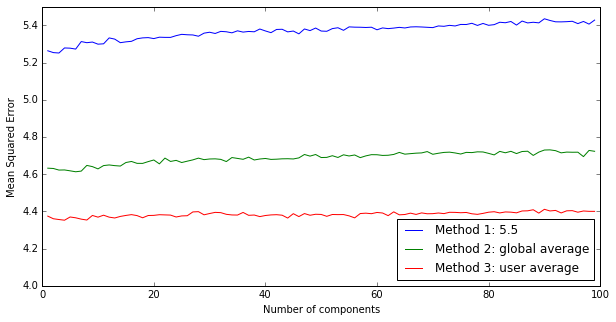

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
x = range(1,100)
plt.figure(figsize=(10,5))
plt.plot(x,res[0], label='Method 1: 5.5')
plt.plot(x,res[1], label='Method 2: global average')
plt.plot(x,res[2], label='Method 3: user average')
plt.ylim([4.0,5.5])
plt.xlabel('Number of components')
plt.ylabel('Mean Squared Error')
plt.legend(loc='best')

We can see that method 3 (using user average to replace missing values) lead to the best performance. We can plot the curves individually to better visualize the effect of the number of components.

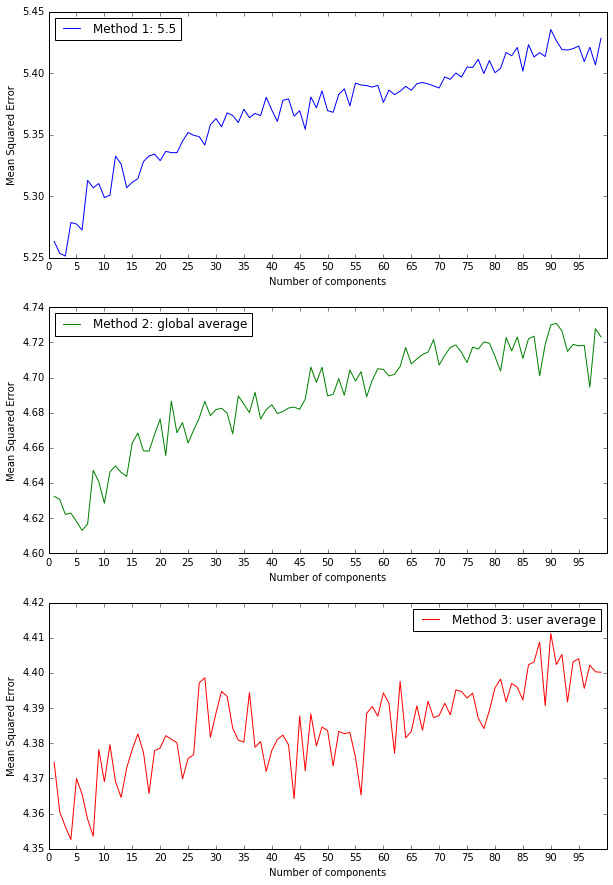

In [22]:
x = range(1,100)
plt.figure(figsize=(10,15))

plt.subplot(3, 1, 1)
plt.plot(x, res[0], label='Method 1: 5.5')
plt.xlabel('Number of components')
plt.ylabel('Mean Squared Error')
plt.xticks(range(0,100, 5))
plt.legend(loc='best')

plt.subplot(3, 1, 2)
plt.plot(x, res[1], 'g', label='Method 2: global average')
plt.xlabel('Number of components')
plt.ylabel('Mean Squared Error')
plt.xticks(range(0,100, 5))
plt.legend(loc='best')

plt.subplot(3, 1, 3)
plt.plot(x, res[2], 'r', label='Method 3: user average')
plt.xlabel('Number of components')
plt.ylabel('Mean Squared Error')
plt.xticks(range(0,100, 5))
plt.legend(loc='best')

We can see that the MSE tends to increase as the number of components increases, but there are minor fluctuations. The best setting is around 3 to 8 components. For method 3, the best setting is at **4 components**. At first, we thought that the more number of latent features the better. However, with too many latent features the model might be overfitting.